Auction Games Network Analysis
=================================

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
font = {'size'   : 10,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [3]:
auction_df = pd.read_csv('/home/nightwing/rsc/Literature-Article/src/data/auction_df.csv')

In [4]:
size = len(auction_df['title'].unique())

In [5]:
file = open("/home/nightwing/rsc/Literature-Article/assets/total_articles_auction.txt", 'w')
file.write('{}'.format(size))
file.close()

**Plot yearly articles.** Articles over the years.

In [6]:
yearly_df = auction_df.groupby(['unique_key', 'date']).size().reset_index().groupby('date').size()

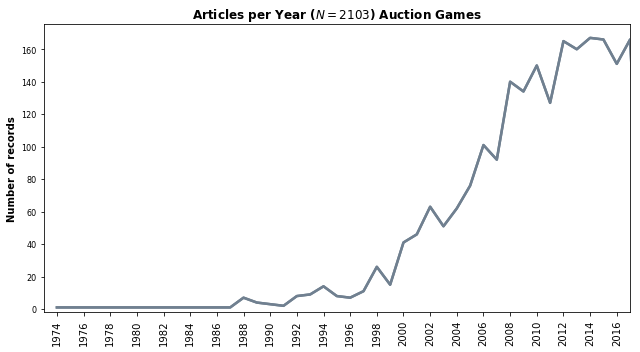

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))

plt.title('Articles per Year ($N={}$) Auction Games'.format(size), fontweight='bold');plt.ylabel('Number of records', fontweight='bold')
ax.plot(yearly_df, color='slategray', zorder=1, linewidth=2.5)
plt.xticks(fontsize=10); plt.yticks(fontsize=8)

plt.plot(yearly_df, color='slategray', zorder=1, linewidth=2.5);

x = yearly_df.index
y = yearly_df.values

ax.set_yticks(np.arange(min(y) - 1, max(y)+1, 20.0))
ax.set_xticks(np.arange(min(x), max(x)+1, 2.0))
ax.set_ylim(ymin=-2)
plt.xticks(rotation=90);
ax.set_xlim(xmin=1973, xmax=2017)
plt.tight_layout()

plt.savefig("/home/nightwing/rsc/Literature-Article/assets/images/auction_timeline.pdf",
           format='pdf', bbox_inches='tight')

**Create the graph**

In [8]:
import networkx as nx
import itertools

import collections

In [10]:
pairs = []
for _, d in auction_df.groupby('unique_key'):
    pairs += tuple(sorted(list(itertools.combinations(d['author'].unique(), 2))))
    co_authors = collections.Counter(pairs)

In [11]:
authors_num_papers = auction_df.groupby(['author', 'unique_key']).size().reset_index().groupby('author').count()
authors_num_papers = authors_num_papers.drop(0, axis=1)

In [12]:
G = nx.Graph()
_ = [G.add_node(name, weight=w) for name, w in zip(auction_df.author, 
                                                   authors_num_papers['unique_key'].values)]
_ = [G.add_edge(*pair[0], weight=pair[1]) for pair in co_authors.items()]

In [13]:
nx.write_gml(G, "../data/auction_network.gml")

**Analyse the graph**

**Order, size, density and average degree.**

In [14]:
order, size = G.order(), G.size()

In [15]:
for measure, label in zip([order, size, nx.density(G), float(2 * size / order)],
                          ['vertices', 'edges', 'density', 'av_degree']):
    file = open("/home/nightwing/rsc/Literature-Article/assets/auction_games_{}.tex".format(label),
                'w')
    file.write('{}'.format(measure))
    file.close()

**Centrality.**

In [16]:
betweeness = sorted(nx.betweenness_centrality(G, weight='weight').items(), 
                    key=lambda x:x[1], reverse=True)[0:10]
betweeness = pd.DataFrame(betweeness, columns=['Author name', 'Betweeness'])
betweeness['Author name'] = [name.title() for name in betweeness['Author name']]

In [17]:
page_rank = sorted(nx.pagerank_numpy(G, weight='weight').items(), 
                   key=lambda x:x[1], reverse=True)[0:10]
page_rank = pd.DataFrame(page_rank, columns=['Author name', 'Page rank'])
page_rank['Author name'] = [name.title() for name in page_rank['Author name']]

In [18]:
closeness_rank = sorted(nx.closeness_centrality(G).items(), 
                   key=lambda x:x[1], reverse=True)[0:10]
closeness_rank = pd.DataFrame(closeness_rank, columns=['Author name', 'Closeness'])
closeness_rank['Author name'] = [name.title() for name in page_rank['Author name']]

In [19]:
for centrality, label in zip([betweeness, page_rank, closeness_rank],
                             ['betweness', 'page_rank', 'closeness']):
    file = open("/home/nightwing/rsc/Literature-Article/assets/auction_games_centrality_{}.tex".format(label),
                'w')
    file.write('{}'.format(pd.DataFrame(centrality).to_latex()))
    file.close()